# Chapter 12: Applying Quantum Algorithms
This Jupyter notebook has been updated to work with Python 3.13, Qiskit v 2.1, Qiskit runtime version: 0.40.
|||
|-|-|
|**Author:** |Robert Loredo|
|**Reviewer:** |Alain Chancé|
|**Date:** |August 28, 2025|
|**Version:** |**2.00**<br/>*Details see at the end of this notebook*|
|**References:**|
[Robert Loredo, Learn Quantum Computing with Python and IBM Quantum: Write your own practical quantum programs with Python, Second Edition, Packt, Feb 25, 2025](https://www.packtpub.com/en-us/product/learn-quantum-computing-with-python-and-ibm-quantum-9781803240923)
[Learning-Quantum-Computing-with-Python-and-IBM-Quantum-Second-Edition/Chapter 12 - Applying Quantum Algorithms - Updated-FinalV2.ipynb](https://github.com/PacktPublishing/Learning-Quantum-Computing-with-Python-and-IBM-Quantum-Second-Edition/blob/main/Chapter%2012%20-%20Applying%20Quantum%20Algorithms%20-%20Updated-FinalV2.ipynb)
[Packt's code repository for the book](https://github.com/PacktPublishing/Learning-Quantum-Computing-with-Python-and-IBM-Quantum-Second-Edition)
[LICENSE](https://github.com/PacktPublishing/Learning-Quantum-Computing-with-Python-and-IBM-Quantum-Second-Edition/blob/main/LICENSE)
[Migrate to the Qiskit Runtime V2 primitives](https://docs.quantum.ibm.com/migration-guides/v2-primitives)
[Qiskit Class QFT](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.QFT)
[Tutorials/Grover's algorithm](https://learning.quantum.ibm.com/tutorial/grovers-algorithm)
<br/>

In [1]:
# Load Helper file
%run helper_file_1.0.ipynb

Token read from file:  Token.txt
Qiskit version: 2.0.0
Qiskit runtime version: 0.37.0
/home/alain/miniconda3/bin/python
Python 3.12.9


# Implementing the QFT algorithm

In [2]:
# Initialize the 3-qubit quantum circuit
# Set the state '110'
s = '110'
num_qubits = len(s)
qc = QuantumCircuit(num_qubits)

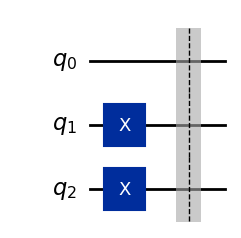

In [3]:
# Set reverse ordering
s = s[::-1] 

# Construct the state 110
for idx in range(num_qubits):
    if s[idx] == '1':
        qc.x(idx)    

qc.barrier()
qc.draw(output='mpl')

Figure 12.1: Initializing the state, $s$, to $|110\rangle$

In [4]:
# Import the value pi for our rotations
from numpy import pi

# Always start from the most significant qubit, 
# in this case it's q2.
# Step 1, add a Hadamard gate
qc.h(2)


In [5]:
# Step 2, add CROT gates from most significant qubit 
qc.cp(pi/2, 1, 2)


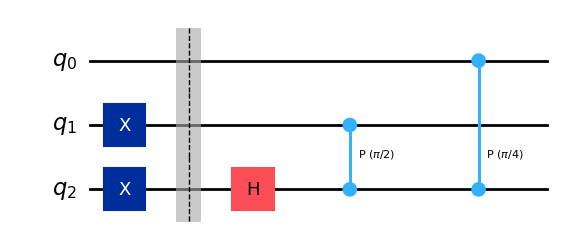

In [6]:
# Step 3, add another CROT from 2 to the next qubit down,
# while doubling the phase denominator
qc.cp(pi/4, 0, 2)

# Draw the circuit
qc.draw(output='mpl')


Figure 12.2: The first set of transformations starting from the most significant qubit

In [7]:
# Now that we finished from 2 down to 0
# We'll drop to the next least significant qubit and start again, 
# Step 1, add a Hadamard gate
qc.h(1)


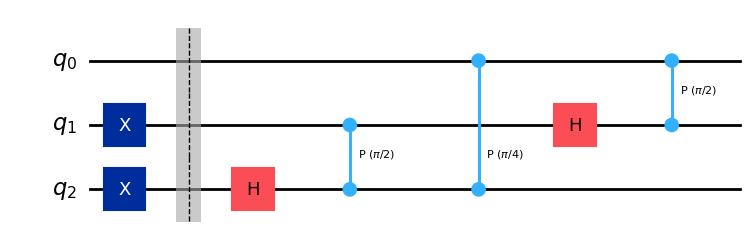

In [8]:
# Step 2, add Control Rotation (CROT) gates from most significant towards 
# least significant starting a pi/2, and doubling the denominator 
# as you go down each qubit. 
qc.cp(pi/2, 0, 1)

# Draw the circuit
qc.draw(output='mpl')


Figure 12.3: The next transformation set starting at the next qubit down

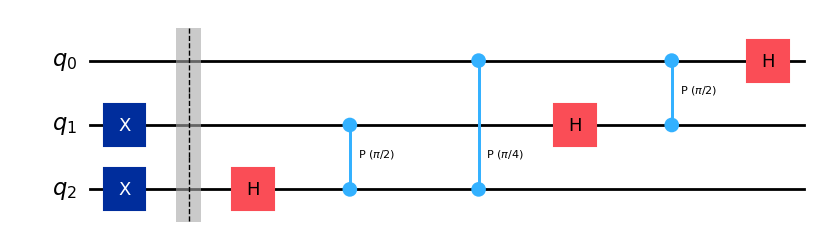

In [9]:
# Step 1, add a Hadamard gate
qc.h(0)
# Since we are at the least significant qubit, we are done!

# Draw the circuit
qc.draw(output='mpl')


Figure 12.4: The final transformation of our QFT circuit

In [10]:
# Define a function which will add the swap gates to the outer 
# pair of qubits
def add_swap_gates(qc_swaps, qubits):
    for qubit in range(qubits//2):
        qc_swaps.swap(qubit, qubits-qubit-1)
    return qc_swaps


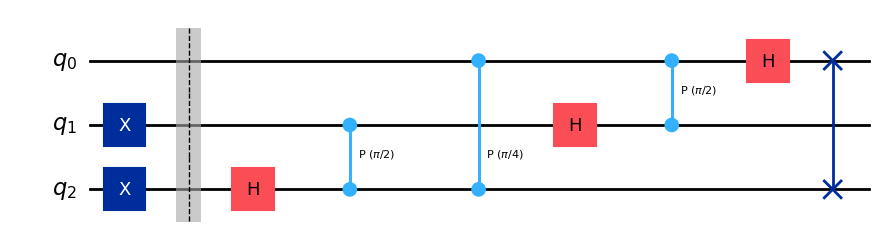

In [11]:
qft_circuit = add_swap_gates(qc, num_qubits)
qft_circuit.draw(output='mpl')


Figure 12.5: The QFT circuit that encodes ‘110’

In [12]:
# Let's define two functions to run our circuits on both a Sampler and a quantum computer

def run_on_sampler(circuit, shots):
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime import SamplerV2 as Sampler
    from qiskit_ibm_runtime.fake_provider import FakeManilaV2
     
    # Run the sampler job locally using FakeManilaV2
    fake_manila = FakeManilaV2()
    pass_manager = generate_preset_pass_manager(backend=fake_manila, optimization_level=1)
    transpiled_qc = pass_manager.run(circuit)
     
    # To ensure we get fixed results, set seed
    options = {"simulator": {"seed_simulator": 10258}}
    sampler = Sampler(mode=fake_manila, options=options)
     
    result = sampler.run([transpiled_qc], shots=shots).result()[0]
    return result

# Run on the least busy quantum computer
def run_on_qc(circuit, shots):
    # At the time of this writing, the latest version of Sampler was SamplerV2. 
    #You may need to update if version numbers have dropped. 
    from qiskit_ibm_runtime import SamplerV2 as Sampler2
    # Assign least busy device to backend
    backend = service.least_busy(min_num_qubits=circuit.num_qubits, simulator=False, operational=True)
    #Print the least busy device
    print('The least busy device: {}'.format(backend))
    #result = {}

    # Transpile the circuit using the preset pass manager
    transpiler = generate_preset_pass_manager(backend=backend, optimization_level=3)
    transpiled_qc = transpiler.run(circuit)

    sampler = Sampler2(backend)
    job = sampler.run([transpiled_qc], shots=shots)
    job_result = job.result()

    # Extract the results 
    result = job_result[0]
        
    return result 

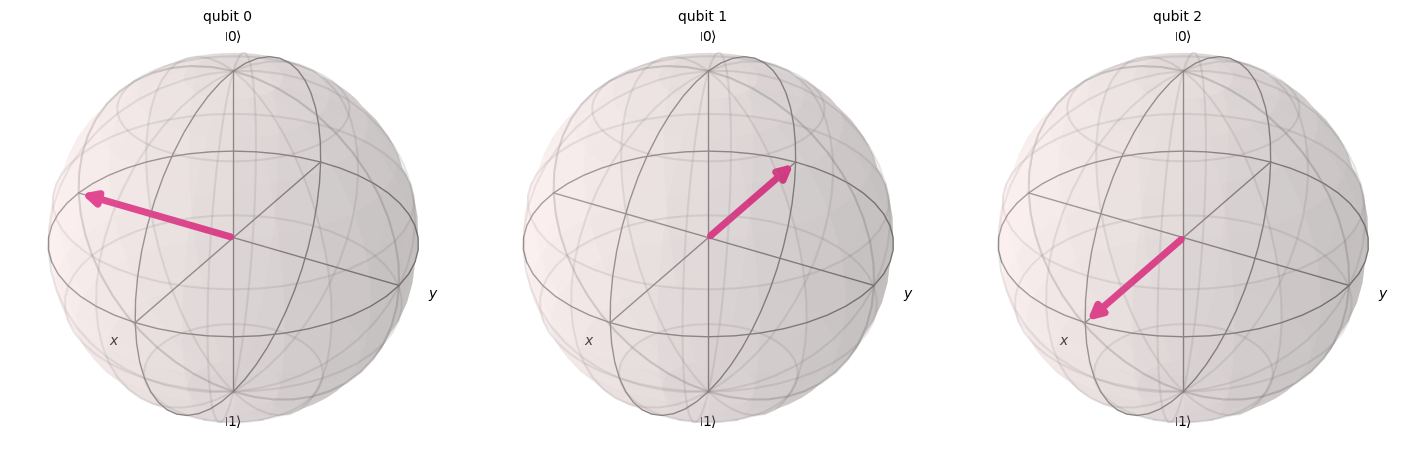

In [13]:
# Get the state vector simulator to view our final QFT state
from qiskit.quantum_info import Statevector
statevector = Statevector(qft_circuit)
plot_bloch_multivector(statevector)


Figure 12.6: A Bloch sphere representation of the ‘110’ QFT encoded value

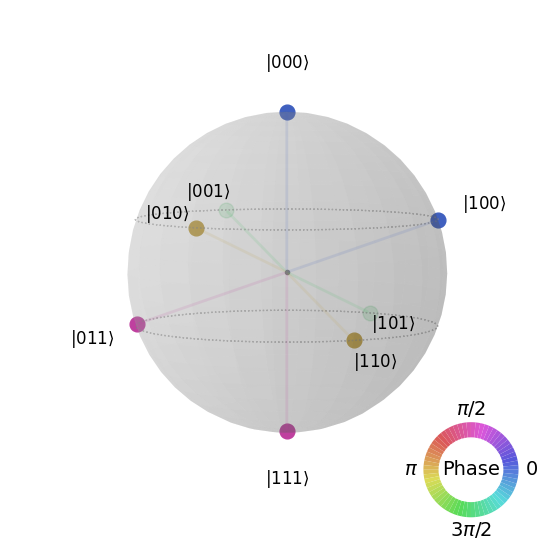

In [14]:
plot_state_qsphere(statevector)

Figure 12.7: A QSphere representation of the QFT representation of the ‘110’ state

# Grover's Algorithm
## Implementing Grover’s search algorithm

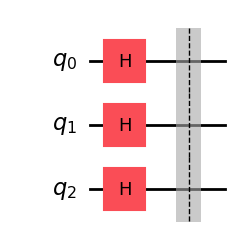

In [15]:
# Set the state we wish to search 
N = '110'
num_qubits = len(N)

# Create the quantum circuit 
qc = QuantumCircuit(num_qubits)

# Set all qubits in superposition
qc.h(range(num_qubits))
qc.barrier()

#Draw the circuit
qc.draw(output='mpl')


Figure 12.11: Initialized quantum circuit in superposition

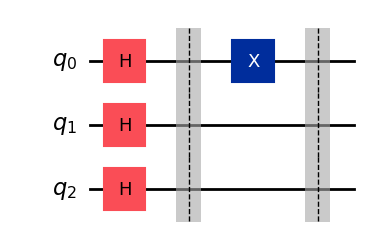

In [16]:
# Reverse the state so it’s in proper qubit ordering
N = N[::-1]

# Encode N into our circuit
for idx in range(num_qubits):
    if N[idx] == '0':
        qc.x(idx)
qc.barrier()

# Draw the circuit
qc.draw(output='mpl')


Figure 12.12: Encoding our state ‘110’, we mark the ‘0’ qubits in the state with an X gate

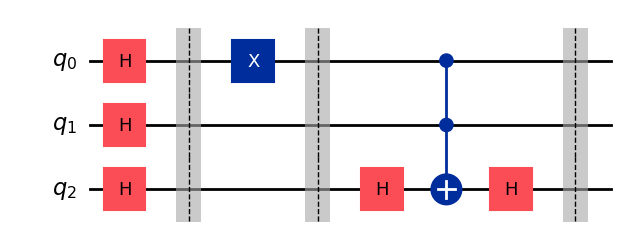

In [17]:
# Create the Grover oracle for our 3-qubit quantum circuit
qc.h(2)
qc.ccx(0, 1, 2)
qc.h(2)
qc.barrier()

# Draw the circuit
qc.draw(output='mpl')


Figure 12.13: Applying Grover’s oracle to the circuit

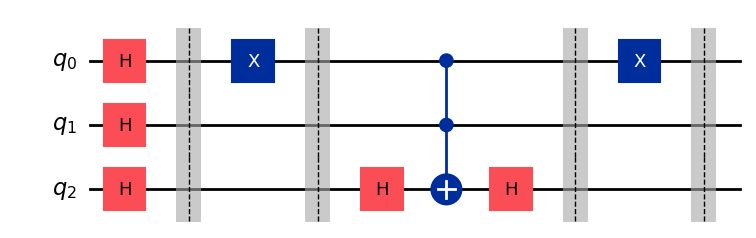

In [18]:
# Reset the value after the oracle
for idx in range(num_qubits):
    if N[idx] == '0':
        qc.x(idx)
qc.barrier()

# Draw the circuit
qc.draw(output='mpl')


Figure 12.14: The first component of Grover’s search algorithm

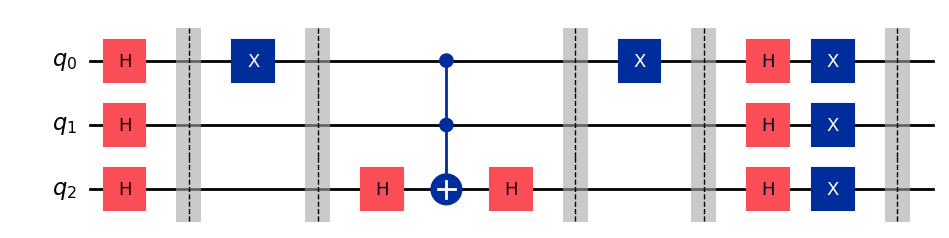

In [19]:
# Set all qubits in superposition
qc.h(range(num_qubits))
qc.x(range(num_qubits))
qc.barrier()

# Draw the circuit
qc.draw(output='mpl')


Figure 12.15: The first step in the Grover diffusion operator: apply $H$ gates to all qubits

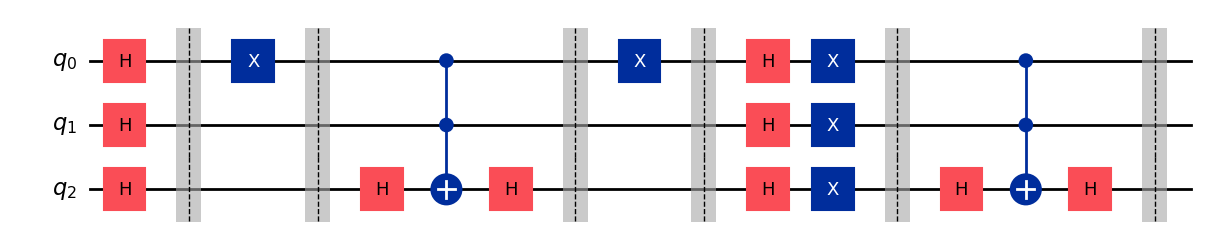

In [20]:
# Apply another oracle, same as the previous, 
qc.h(2)
qc.ccx(0, 1, 2)
qc.h(2)
qc.barrier()

# Draw the circuit
qc.draw(output='mpl')


Figure 12.16: The second step of the diffusion operator: to invert about the mean

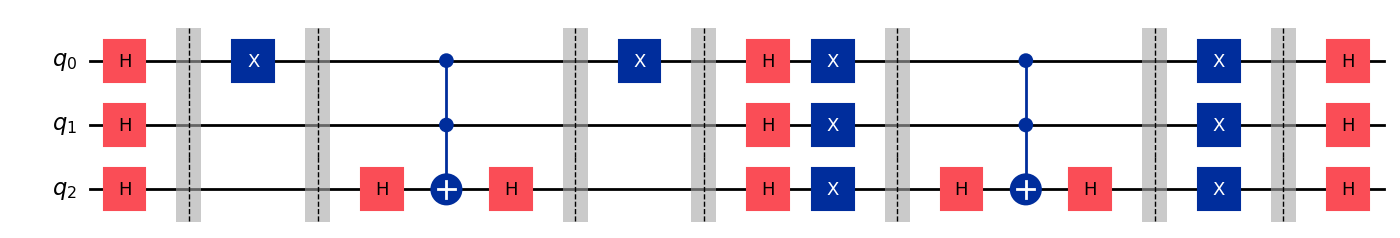

In [21]:
# Reapply the X rotations on all qubits
qc.x(range(num_qubits))

qc.barrier()

# Reapply Hadamard gates to all qubits
qc.h(range(num_qubits))

# Draw the circuit
qc.draw(output='mpl')


Figure 12.17: The complete Grover’s algorithm circuit

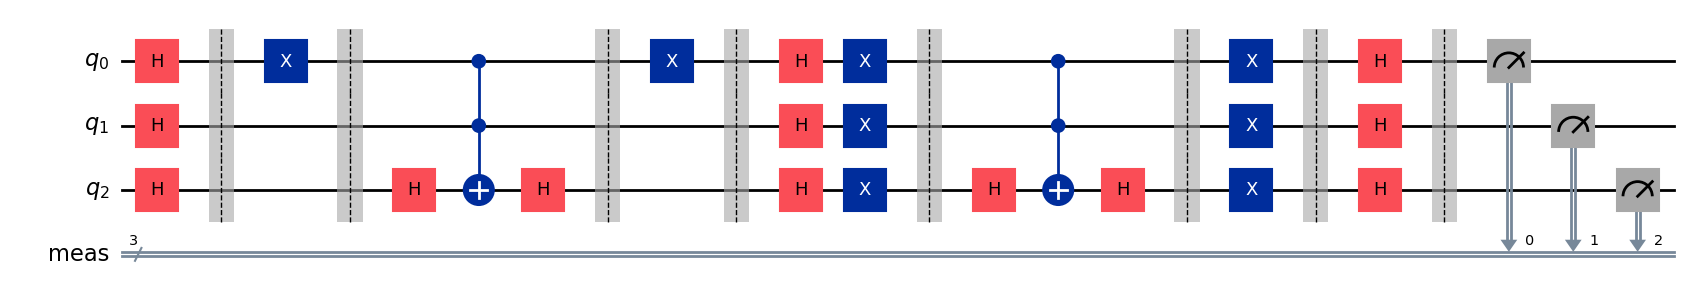

In [22]:
# Add measurement operators
qc.measure_all()

# Draw the circuit
qc.draw(output='mpl')



Figure 12.18: The complete quantum circuit ready to run on a simulator or quantum system

The counts are: {'100': 31, '111': 35, '110': 801, '011': 25, '000': 38, '001': 38, '010': 35, '101': 21}


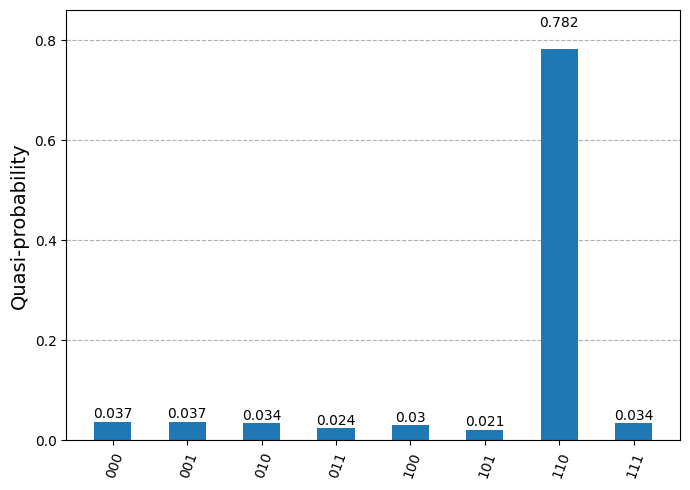

In [23]:
# Added by Alain Chancé
result = run_qasm_simulator(qc)
counts = result.get_counts(qc)

# Print and plot results
# Modified by Alain Chancé
#print(counts)
print(f"The counts are: {counts}")
plot_distribution(counts)

Figure 12.19: Results of executing Grover’s search of state $110$ on a quantum simulator

### Run Grover's algorithm on a quantum computer

In [24]:
# Run the circuit on the least busy quantum computer
backend = service.least_busy(min_num_qubits = num_qubits, simulator=False, operational=True)
print("Set backend: ", backend)

Set backend:  <IBMBackend('ibm_brisbane')>


In [25]:
# Run the circuit on the backend
shots = 1000
results = run_on_qc(qc, shots)
print(results)


The least busy device: <IBMBackend('ibm_kyiv')>
SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1000, num_bits=3>)), metadata={'circuit_metadata': {}})


In [26]:
counts = results.data.meas.get_counts()
# Print results
print(counts)

{'101': 36, '110': 648, '100': 58, '010': 61, '111': 49, '001': 42, '011': 49, '000': 57}


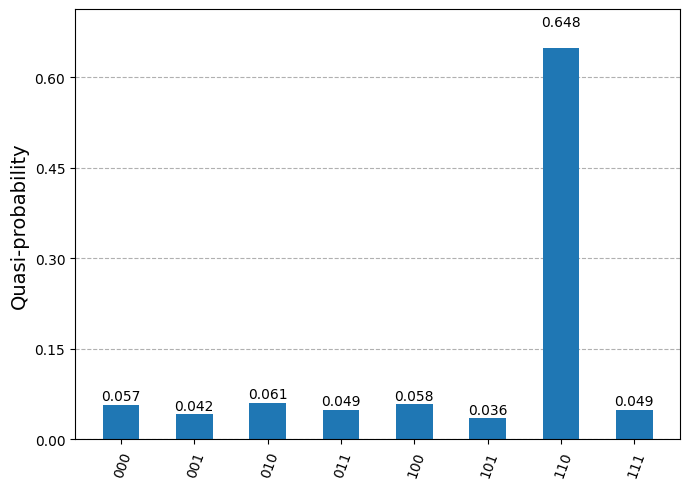

In [27]:
# Added by Alain Chancé
# Plot results
plot_distribution(counts)

Figure 12.20: Probability distribution

In [28]:
!pip list | grep qiskit

qiskit                                   2.0.0
qiskit-aer                               0.17.0
qiskit-algorithms                        0.3.1
qiskit-dynamics                          0.5.1
qiskit-ibm-catalog                       0.5.0
qiskit-ibm-runtime                       0.37.0
qiskit-nature                            0.7.2
qiskit-serverless                        0.21.1
qiskit_utils                             1.2.1


## Qiskit packages versions

In [23]:
import qiskit
import qiskit_ibm_runtime
import qiskit_aer

print(f'Qiskit: {qiskit.__version__}')
print(f'Qiskit IBM Runtime: {qiskit_ibm_runtime.__version__}')
print(f"Qiskit Aer version: {qiskit_aer.__version__}")

Qiskit: 2.1.1
Qiskit IBM Runtime: 0.40.1
Qiskit Aer version: 0.17.1


## Show Python version

In [31]:
%%bash
which python
python --version

/home/alain/miniconda3/bin/python
Python 3.12.9
